In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
from pathlib import Path
import torchaudio
import fairseq
import torch
device = torch.device('cuda')
device

device(type='cuda')

In [4]:
def get_mos_data(split):
    mos_list_file = f'../data/phase1-main/DATA/sets/{split}_mos_list.txt'
    mos_data = {}
    for line in open(mos_list_file):
        file_id, mos = line.rstrip().split(',')
        mos = float(mos)
        mos_data[file_id] = mos
    return mos_data

In [5]:
train_mos_data = get_mos_data('train')
len(train_mos_data)

4974

In [6]:
val_mos_data = get_mos_data('val')
len(val_mos_data)

1066

In [7]:
wav_dir = Path('../data/phase1-main/DATA/wav/')

wavpath = wav_dir / 'sys64e2f-utt9c183cd.wav'
wav = torchaudio.load(wavpath)[0]
wav.size()

torch.Size([1, 42944])

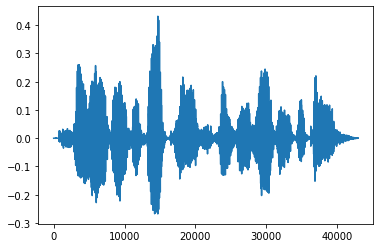

In [8]:
plt.plot(wav.numpy().ravel())

In [10]:
fairseq_base_model = '../fairseq/hubert_large_ll60k.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([fairseq_base_model])


2022-02-06 02:27:13 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/koriyama/voicemos/220131ensemble/voiceMOS2022/notebooks
2022-02-06 02:27:13 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': '/checkpoint/wnhsu/data/librivox', 'fine_tuning': False, 'labels': ['lyr9.km500'], 'label_dir': '/checkpoint/wnhsu/experiments/hubert/kmeans_20210121/km_dataset_librivox.model_iter_2.all', 'label_rate': 50, 'sample_rate': 16000, 'normalize': True, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2022-02-06 02:27:13 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50, 'extractor_mode': layer_norm, 'encoder_layers': 24, 'encoder_embed_dim': 1024, 'encoder_ffn_embed_dim': 4096, 'encoder_attention_heads': 16, 'activation_fn': gelu, 'dropout': 0.0, 'attenti

In [12]:
ssl_model = model[0]

In [13]:
ssl_model.remove_pretraining_modules()
ssl_model.to(device)
ssl_model.eval();

In [14]:
output_wavs = torch.stack([wav], dim=0)
output_wavs.size()

torch.Size([1, 1, 42944])

In [15]:
res = ssl_model(wav.to(device), mask=False, features_only=True)
res

{'x': tensor([[[-0.1301,  0.1909,  0.1484,  ...,  0.1930,  0.3408,  0.0718],
          [-0.2097,  0.1157,  0.1261,  ...,  0.0530,  0.3933,  0.1282],
          [-0.0975,  0.2244,  0.1576,  ...,  0.0728,  0.0817,  0.3525],
          ...,
          [-0.1437,  0.1040,  0.1476,  ...,  0.0969, -0.3507,  0.1105],
          [-0.0902,  0.1331,  0.1255,  ...,  0.3533, -0.1115,  0.1072],
          [-0.1704,  0.1254, -0.0145,  ...,  0.3137,  0.1045,  0.0649]]],
        device='cuda:0', grad_fn=<NativeLayerNormBackward0>),
 'padding_mask': None,
 'features': tensor([[[ 2.4050,  0.3370,  5.7001,  ..., -1.3709, -0.5664,  1.4819],
          [ 2.5383,  0.0532,  5.6959,  ..., -1.4146, -0.4535,  1.4391],
          [ 1.7525, 17.6515,  2.7284,  ..., -2.5450, -1.5924, -7.3750],
          ...,
          [ 0.3254,  7.2919,  2.9956,  ..., -3.6404, -1.6446,  1.7718],
          [ 2.1465, 10.3307,  4.0272,  ..., -2.8706, -1.0084, -2.5108],
          [ 1.4856,  4.1097,  2.6139,  ..., -2.5779, -0.2800,  0.0831]]],


In [16]:
res['x'].size()

torch.Size([1, 133, 1024])

In [17]:
res['features'].size()

torch.Size([1, 133, 1024])

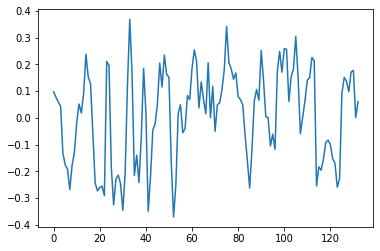

In [25]:
plt.plot(res['x'].squeeze(0)[:, 350].detach().cpu().numpy())

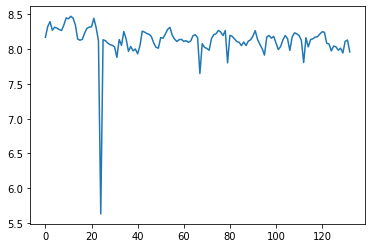

In [27]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=1).detach().cpu().numpy())

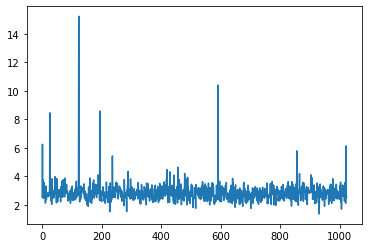

In [28]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=0).detach().cpu().numpy())

In [29]:
def extract_mean(wavpath):
    with torch.no_grad():
        wav = torchaudio.load(wavpath)[0]
        res = ssl_model(wav.to(device), mask=False, features_only=True)
        return res['x'].squeeze(0).mean(dim=0)


In [30]:
extract_mean(wavpath).size()

torch.Size([1024])

In [31]:
out_dir = Path('../out/utt_data/hubert_large')
import os
os.makedirs(out_dir, exist_ok=True)


In [32]:
val_vecs = []
val_moss = []

for key, mos in tqdm(sorted(val_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    val_vecs.append(vec)
    val_moss.append(mos)

  0%|          | 0/1066 [00:00<?, ?it/s]

In [34]:
train_vecs = []
train_moss = []

for key, mos in tqdm(sorted(train_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    train_vecs.append(vec)
    train_moss.append(mos)

  0%|          | 0/4974 [00:00<?, ?it/s]

In [35]:
train_X = np.array(train_vecs)
train_y = np.array(train_moss)
val_X = np.array(val_vecs)
val_y = np.array(val_moss)
train_X.shape

(4974, 1024)

In [36]:
uttemb_dir = Path('../out/utt_emb/hubert_large')
os.makedirs(uttemb_dir)
np.save(uttemb_dir / 'train_X.npy', train_X)
np.save(uttemb_dir / 'train_y.npy', train_y)
np.save(uttemb_dir / 'val_X.npy', val_X)
np.save(uttemb_dir / 'val_y.npy', val_y)